In [2]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [3]:
!pip install torchinfo

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import medmnist
from medmnist import INFO
from torchvision import transforms
from torch.utils.data import Subset
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
data_flag = 'octmnist'
info = INFO[data_flag]
n_classes = len(info['label'])
task = info['task']
class_labels = info['label']

#Retreivve dataset and preprocessing

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
    ])

In [6]:
train_dataset = medmnist.OCTMNIST(split='train', transform=transform, download=True)
val_dataset = medmnist.OCTMNIST(split='val', transform=transform, download=True)
test_dataset = medmnist.OCTMNIST(split='test', transform=transform, download=True)

In [ ]:
vis_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
images, labels = next(iter(vis_loader))
metadata = pd.DataFrame({
    'Label': labels.numpy().flatten(),
    'Class': [class_labels[str(label)] for label in labels.numpy().flatten()]
})
print("Top 5 Rows of OCTMNIST Dataset Metadata:")
print(metadata.head())

Top 5 Rows of OCTMNIST Dataset Metadata:
   Label                         Class
0      0  choroidal neovascularization
1      0  choroidal neovascularization
2      3                        normal
3      3                        normal
4      0  choroidal neovascularization


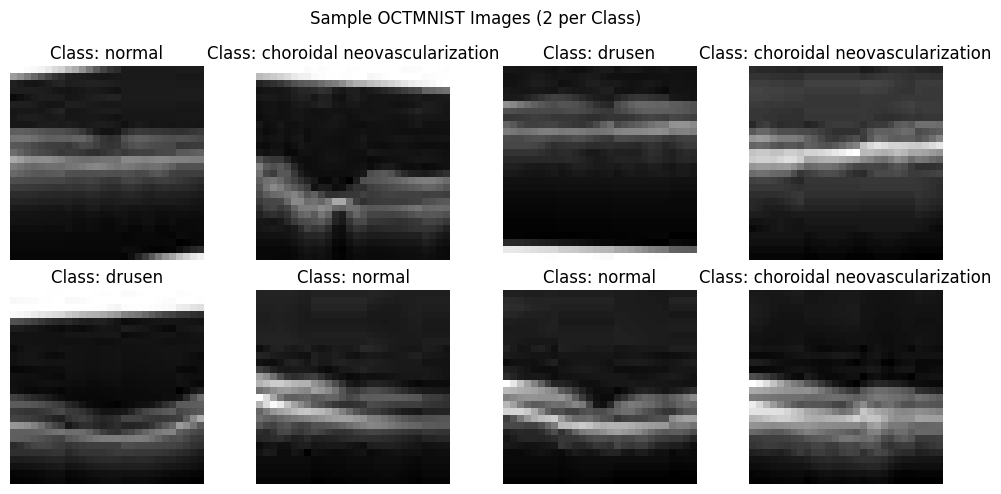

In [ ]:
#Display sample images (2 per class)
plt.figure(figsize=(10, 5))
images, labels = next(iter(vis_loader))  # Get a batch
for i, (img, label) in enumerate(zip(images[:8], labels[:8])):
  plt.subplot(2, 4, i + 1)
  img = img.squeeze().numpy()  # Remove channel dimension
  img = (img * 0.5 + 0.5)  # Denormalize to [0, 1] for display
  plt.imshow(img, cmap='gray')
  plt.title(f"Class: {class_labels[str(label.item())]}")
  plt.axis('off')
plt.suptitle('Sample OCTMNIST Images (2 per Class)')
plt.tight_layout()
plt.show()

#Visualization

<ipython-input-17-d6d92d05bc6c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette='viridis')


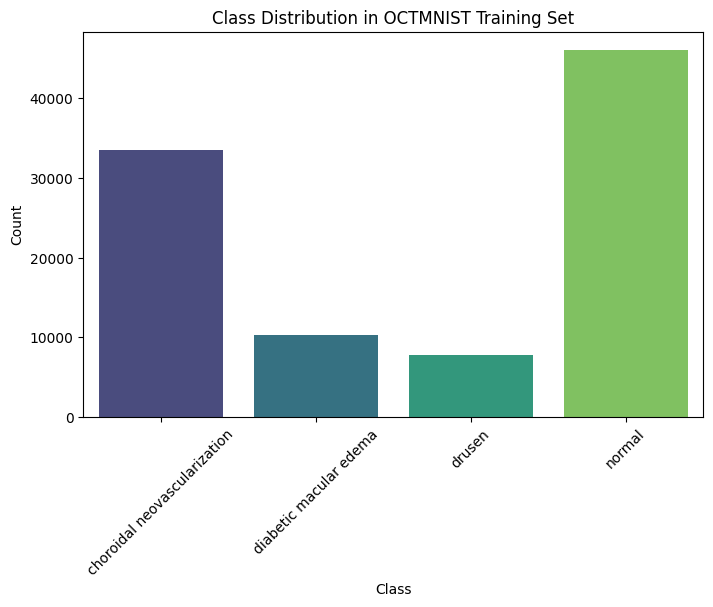

In [ ]:
#Class Distribution
train_labels = [label.item() for _, label in train_dataset]
plt.figure(figsize=(8, 5))
sns.countplot(x=train_labels, palette='viridis')
plt.xticks(ticks=range(n_classes), labels=[class_labels[str(i)] for i in range(n_classes)], rotation=45)
plt.title('Class Distribution in OCTMNIST Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

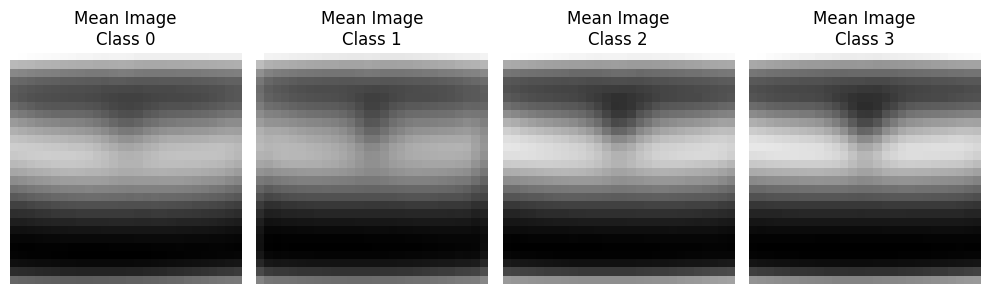

In [ ]:
#Average Image per Class
mean_images = []
for c in range(4):  # 4 classes in OCTMNIST
  imgs = torch.stack([img[0] for img in train_dataset if img[1] == c])
  mean_img = imgs.mean(dim=0)
  mean_images.append(mean_img)

plt.figure(figsize=(10, 3))
for i, img in enumerate(mean_images):
  plt.subplot(1, 4, i + 1)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(f"Mean Image\nClass {i}")
  plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
print(f'Dataset: {data_flag}')
print(f'Number of classes: {n_classes}')
print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')

Dataset: octmnist
Number of classes: 4
Train samples: 97477
Validation samples: 10832
Test samples: 1000
Image shape: torch.Size([1, 28, 28])


#Building model

##Baseline model

In [23]:
class BaselineCNN(nn.Module):
  def __init__(self):
    super(BaselineCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16,kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 32,kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)
    self.flatten= nn.Flatten()
    self.fc1= nn.Linear(32 * 7 * 7, 128)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(128, n_classes)

  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.flatten(x)
    x = self.relu3(self.fc1(x))
    x = self.fc2(x)
    return x

###Training setup

In [24]:
base_model = BaselineCNN().to(device)
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(base_model.parameters(), lr=0.001)

###Training loop

In [25]:
num_epochs = 6
base_train_losses, base_val_losses = [], []
base_train_accuracies, base_val_accuracies = [], []

start_time = time.time()
for epoch in range(num_epochs):
  base_model.train()
  train_loss, train_correct, train_total = 0, 0, 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device).squeeze().long()
    outputs = base_model(images)
    loss = criterion(outputs, labels)
    base_optimizer.zero_grad()
    loss.backward()
    base_optimizer.step()
    train_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  train_loss /= len(train_loader.dataset)
  train_accuracy = train_correct / train_total
  base_train_losses.append(train_loss)
  base_train_accuracies.append(train_accuracy)

  base_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device).squeeze().long()
      outputs = base_model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item() * images.size(0)
      _, predicted = torch.max(outputs, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

  val_loss /= len(val_loader.dataset)
  val_accuracy = val_correct / val_total
  base_val_losses.append(val_loss)
  base_val_accuracies.append(val_accuracy)
  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
baseline_training_time = time.time() - start_time

Epoch 1/6, Train Loss: 0.7219, Train Acc: 0.7356, Val Loss: 0.5322, Val Acc: 0.8153
Epoch 2/6, Train Loss: 0.5082, Train Acc: 0.8186, Val Loss: 0.4856, Val Acc: 0.8290
Epoch 3/6, Train Loss: 0.4498, Train Acc: 0.8398, Val Loss: 0.4199, Val Acc: 0.8507
Epoch 4/6, Train Loss: 0.4107, Train Acc: 0.8535, Val Loss: 0.3933, Val Acc: 0.8605
Epoch 5/6, Train Loss: 0.3827, Train Acc: 0.8645, Val Loss: 0.3692, Val Acc: 0.8684
Epoch 6/6, Train Loss: 0.3579, Train Acc: 0.8723, Val Loss: 0.3511, Val Acc: 0.8746


###Evaluation

In [26]:
base_model.eval()
base_test_loss, base_test_correct, base_test_total = 0, 0, 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device).squeeze().long()
    outputs = base_model(images)
    loss = criterion(outputs, labels)
    base_test_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    base_test_total += labels.size(0)
    base_test_correct += (predicted == labels).sum().item()

base_test_loss /= len(test_loader.dataset)
baseline_test_accuracy = base_test_correct / base_test_total
print(f"Baseline Test Loss: {base_test_loss:.4f}, Baseline Test Accuracy: {baseline_test_accuracy:.4f}")

Baseline Test Loss: 0.8984, Baseline Test Accuracy: 0.6580


##Improved model

In [9]:
class OCTMNIST_CNN(nn.Module):
  def __init__(self):
    super(OCTMNIST_CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(32 * 7 * 7, 128)
    self.relu3 = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, n_classes)

  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.flatten(x)
    x = self.relu3(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

###Training set

In [10]:
model = OCTMNIST_CNN().to(device)
from torchinfo import summary
summary(model, input_size=(batch_size, 1, 28, 28))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
#early stopping parameters
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0
best_model_weights = None

In [13]:
num_epochs = 6
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

###Training loop

In [14]:
start_time = time.time()
for epoch in range(num_epochs):
  model.train()
  train_loss, train_correct, train_total = 0, 0, 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device).squeeze().long()
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  train_loss /= len(train_loader.dataset)
  train_accuracy = train_correct / train_total
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  #Validation phase
  model.eval()
  val_loss, val_correct, val_total = 0, 0, 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device).squeeze().long()
      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item() * images.size(0)
      _, predicted = torch.max(outputs, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

  val_loss /= len(val_loader.dataset)
  val_accuracy = val_correct / val_total
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

  #Learning rate scheduler step
  scheduler.step()

  #Early stopping
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model_weights = model.state_dict().copy()
    early_stop_counter = 0
    torch.save(best_model_weights, 'a0_part_3_nsoni.pt')
    print('Best model weights saved')
  else:
    early_stop_counter += 1
    if early_stop_counter >= patience:
      print('Early stopping triggered')
      break
training_time = time.time() - start_time
print(f'Training Time: {training_time:.2f} seconds')


Epoch 1/6, Train Loss: 0.7755, Train Acc: 0.7147, Val Loss: 0.5726, Val Acc: 0.7977
Best model weights saved
Epoch 2/6, Train Loss: 0.5533, Train Acc: 0.8107, Val Loss: 0.4821, Val Acc: 0.8314
Best model weights saved
Epoch 3/6, Train Loss: 0.4970, Train Acc: 0.8296, Val Loss: 0.4407, Val Acc: 0.8490
Best model weights saved
Epoch 4/6, Train Loss: 0.4590, Train Acc: 0.8419, Val Loss: 0.4167, Val Acc: 0.8542
Best model weights saved
Epoch 5/6, Train Loss: 0.4281, Train Acc: 0.8529, Val Loss: 0.3865, Val Acc: 0.8648
Best model weights saved
Epoch 6/6, Train Loss: 0.4096, Train Acc: 0.8587, Val Loss: 0.3857, Val Acc: 0.8633
Best model weights saved
Training Time: 133.25 seconds


###Evaluation

In [15]:
#Load best model weights
model.load_state_dict(best_model_weights)

<All keys matched successfully>

In [16]:
model.eval()
test_loss, test_correct, test_total = 0, 0, 0
test_predictions, test_labels = [], []
test_probs = []
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device).squeeze().long()
    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()
    test_predictions.extend(predicted.cpu().numpy())
    test_labels.extend(labels.cpu().numpy())
    test_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = test_correct / test_total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.8033, Test Accuracy: 0.6750


In [17]:
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='weighted')
print(f'Test Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Test Precision: 0.7159, Recall: 0.6750, F1 Score: 0.6063


#Plots

##Improved model visualizations

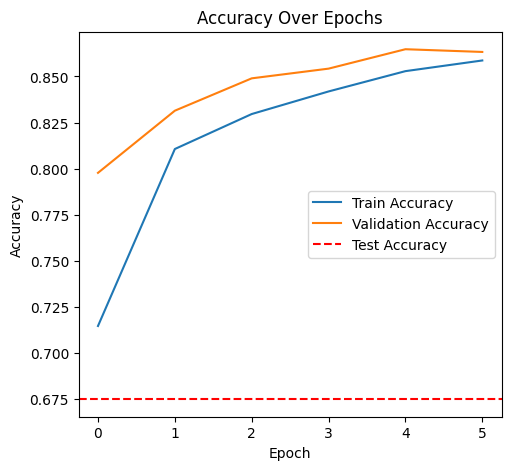

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

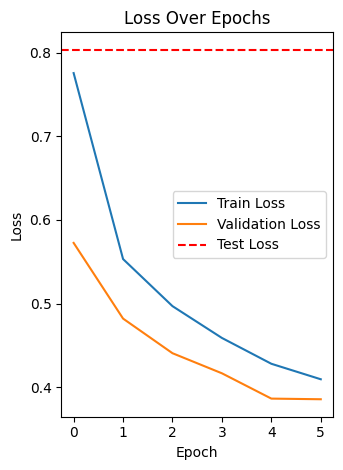

In [19]:
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

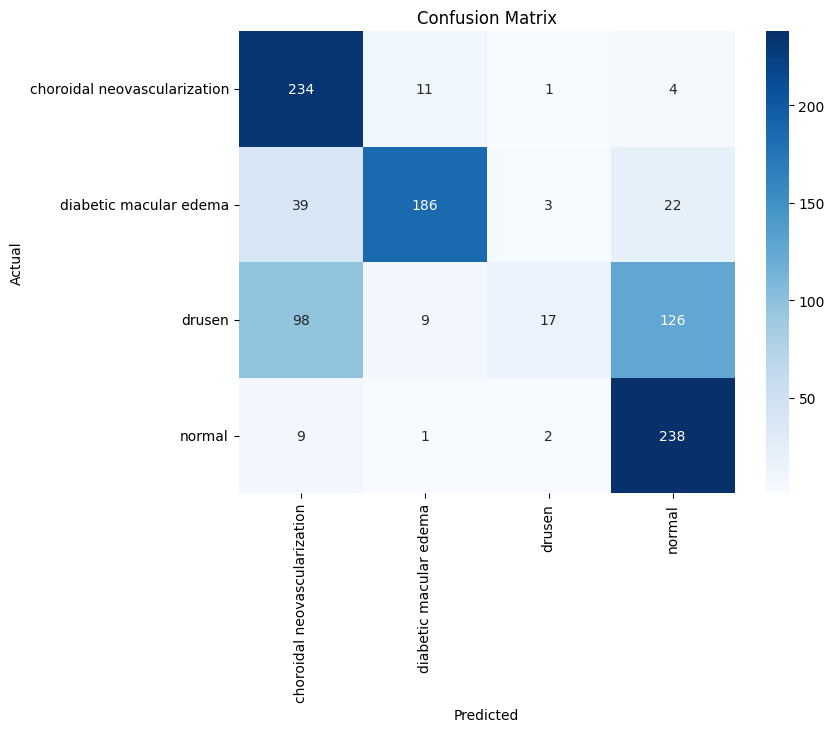

In [20]:
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

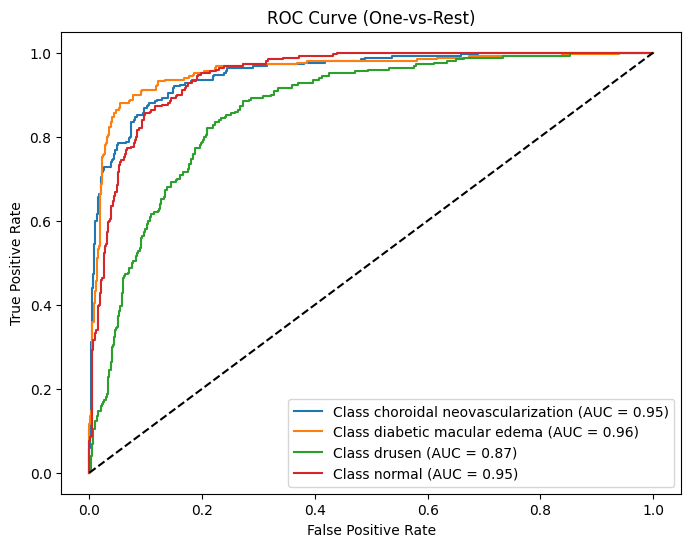

In [21]:
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(np.array(test_labels) == i, np.array(test_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {info["label"][str(i)]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##Baseline vs Improved model comparison

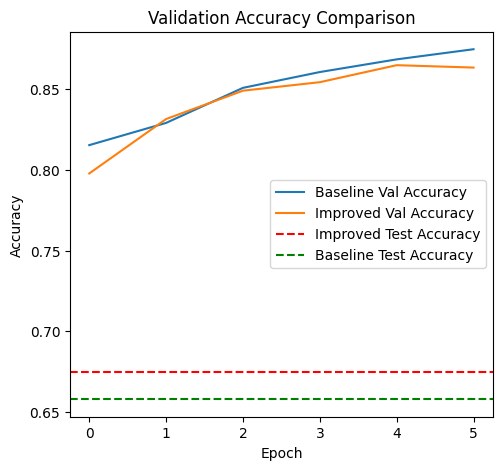

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(base_val_accuracies, label='Baseline Val Accuracy')
plt.plot(val_accuracies, label='Improved Val Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Improved Test Accuracy')
plt.axhline(y=baseline_test_accuracy, color='g', linestyle='--', label='Baseline Test Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

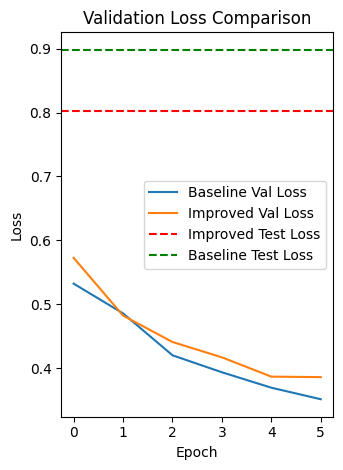

In [28]:
plt.subplot(1, 2, 2)
plt.plot(base_val_losses, label='Baseline Val Loss')
plt.plot(val_losses, label='Improved Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Improved Test Loss')
plt.axhline(y=base_test_loss, color='g', linestyle='--', label='Baseline Test Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()